# Sketched ridgeless least square 

With fixed n, p, varying m to validate the theoretical out-of-sample risk derived in theorem 3.2.

In [1]:
from sklearn.base import RegressorMixin
from scipy.stats import ortho_group # orthogonal matrix

import numpy as np
import math

import os
import json, codecs

import scienceplots
import seaborn as sns
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

import scienceplots
import matplotlib.pyplot as plt 

### Orthogonal matrix

There are multiple approaches to generate an orthogonal matrix in Python. One method involves utilizing the ortho_group function from the scipy.stats module. Another faster alternative is to employ the Fast Fourier Transform (FFT) algorithm. In this notebook, we provide our own implementation inspired by the work of [Sketching-lr](https://github.com/liusf15/Sketching-lr)  to generate the orthogonal matrix using the FFT algorithm.

In [2]:
from scipy.fftpack import dct
import numpy as np

def generate_harr_matrix(n, p):
    if n <= p:
        return np.linalg.qr(np.random.randn(p,n))[0].T
    else:
        return np.linalg.qr(np.random.randn(p,n))[0]

def hadamard_projection(X, r):
    n, p = X.shape
    X_tilde = np.concatenate([X, np.zeros((n, 1))], axis=1)
    X[: int(n / 2), :] = -X[: int(n/2), :]
    np.random.shuffle(X)
    X_tilde_dct = dct(X, axis=0, norm='ortho')
    #X_tilde_dct[0, :] = X_tilde_dct[0:, ] / np.sqrt(n)
    idx_sample = np.random.choice(n, r, replace=False)
    X_tilde_sampled = X_tilde_dct[idx_sample, :p]

    return X_tilde_sampled

def generate_orthogonal_matrix(n):
    X = generate_harr_matrix(n, n)
    S = hadamard_projection(X, n)
    return S


In [16]:
S = generate_orthogonal_matrix(80)
def is_orthogonal(matrix):
    product = np.dot(matrix, matrix.T)
    identity = np.eye(matrix.shape[0])
    return np.allclose(product, identity)
is_orthogonal(S)

True

# Sketched estimator

In [2]:
class SketchedRidgelessRegressor(RegressorMixin):
    """Sketched Ridgeless regression using Moore Penrose pseudoinverse."""

    def __init__(self):
        self.beta = None

    def fit(self, x, y, m, is_orthogonal=True):
        n = x.shape[0]
        p = x.shape[1]
        
        # Given S
        np.random.seed(1234)
        
        if is_orthogonal:
            S = generate_orthogonal_matrix(n)[0:m, :]
            #S = ortho_group.rvs(dim=n)[0:m, :]   # orthogonal schetching matrix
        else:
            S = np.random.normal(size=(m, n), scale=1/np.sqrt(n))    # iid schetching matrix

        sx = np.matmul(S, x)
        sy = np.matmul(S, y)

        # xxinv = np.linalg.pinv(np.matmul(sx.T, sx))
        # xy = np.matmul(sx.T, sy)
        
        Ip = np.eye(p)
        xxinv = np.linalg.inv(np.matmul(sx.T, sx)/n + 1e-9 * Ip)
        xy = np.matmul(sx.T, sy)/n
        
        self.beta = np.matmul(xxinv, xy)
        return self

    def predict(self, x):
        return np.matmul(x, self.beta)

# Data generation

- Assumption 2.2, $\beta \sim \mathcal{N}_p\left(0, \frac{\alpha^2}{p} I_p\right)$, where $||\beta||^2_2 \to \alpha^2$, independent of the data matrix $X$, noise $\epsilon$, sketching matrix $S$
- Assumption 2.1, for $i = 1, \dots, n$, $x_i = \Sigma^{1/2} z_i$ where $z_i$ iid components with mean 0 and variance 1 and finite 4-th moment; $\epsilon \perp X$, $E[\epsilon]=0, Var(\epsilon)=\sigma^2$


In [3]:
def gen_train_dat(n_train, n_features, alpha, sigma, seed):
    """
    n_samples: n
    n_features: p
    alpha: beta's norm
    sigma: sigma
    """

    #bet = norm / np.sqrt(p) * np.ones(p) 
    
    # seed for fixed X
    np.random.seed(1234)

    # Assumption 2.1 (model specification)
    x = np.random.normal(size=(n_train, n_features), scale=1)
    
    # seed for eps, beta
    np.random.seed(seed+3524)
    
    # Assumption 2.2 (random beta)
    bet = alpha / np.sqrt(n_features) * np.random.normal(size=n_features)  #from guassian prior
    eps = np.random.normal(size=n_train, scale=sigma)
    y = np.matmul(x, bet) + eps

    return x, y, bet

In [4]:
def gen_test_dat(n_test, n_features, beta, sigma, seed):
    
    # seed for x0 and eps
    np.random.seed(seed+1234)
    
    x0 = np.random.normal(size=(n_test, n_features), scale=1)
    eps = np.random.normal(size=n_test, scale=sigma)
    y = np.matmul(x0, beta) + eps

    return x0, y

# Theorem 3.2

Theorem 3.2. Suppose Assumptions 2.1, 2.2 and 2.5 hold, and also suppose $\Sigma=I_p$. Then it holds almost surely that as $m, n, p \rightarrow \infty$, with $p / n \rightarrow \phi, m / n \rightarrow \psi \in(0,1)$, if

(i) $S$ is an orthogonal sketching matrix,
$$
R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right) \rightarrow \begin{cases}\frac{\sigma^2 \phi \psi^{-1}}{1-\phi \psi^{-1}}, & \phi \psi^{-1}<1, \\ \alpha^2\left(1-\psi \phi^{-1}\right)+\frac{\sigma^2}{\phi \psi^{-1}-1}, & \phi \psi^{-1}>1 .\end{cases}
$$
(ii) $S$ is an i.i.d. sketching matrix,
$$
R_{(S, X)}(\widehat{\beta} ; \beta) \rightarrow \begin{cases}\frac{\sigma^2 \phi}{1-\phi}+\frac{\sigma^2 \phi \psi^{-1}}{1-\phi \psi^{-1}}, & \phi \psi^{-1}<1, \\ \alpha^2\left(1-\psi \phi^{-1}\right)+\frac{\sigma^2}{\phi \psi^{-1}-1}, & \phi \psi^{-1}>1 .\end{cases}
$$
Besides, $R_{(\beta, S, X)}\left(\widehat{\beta}^S ; \beta\right)$ converges almost surely to the same limit.

In [5]:
def asy_risk_sketching(n, p, m, alpha, is_orthogonal=True, sigma=1):
    """
    gamma: p/n
    psi: m/n
    norm: alpha in Lemma 3.2
    """

    phi = p / n
    psi = m / n
    condition = phi / psi

    # condition < 1
    if is_orthogonal:
        r_up = sigma**2 * condition / (1 - condition)
    else:
        r_up = sigma**2 * phi / (1 - phi) + sigma**2 * condition / (1 - condition)

    # condition > 1
    r_op = alpha**2 * (1 - 1/condition) + sigma**2 / (condition - 1)

    r = (condition < 1) * r_up + (condition > 1) * r_op

    return r

## Simulation

In [6]:
def simulate(n_train, n_features, m, alpha, sigma, seed, is_orthogonal=True, n_test=1):
    
    # train
    x, y, beta = gen_train_dat(n_train, n_features, alpha, sigma, seed)  

    # test
    x_oos, y_oos = gen_test_dat(n_test, n_features, beta, sigma, seed)

    # fit ridgeless least square using sketching matrix
    ridgeless = SketchedRidgelessRegressor()
    ridgeless = ridgeless.fit(x, y, m, is_orthogonal)
    
    # calculate mse
    test_mse = np.mean((np.matmul(x_oos, ridgeless.beta) - np.matmul(x_oos, beta))**2)

    return test_mse

In [29]:
n_train = 400
n_test = 100
n_features = 200

alpha = 15
sigma = 5
seed = 12341234
n_sim = 500

n_pts = 20                 # number of points in the graph for visualizing empirical results (dots)
n_pts_asymp = 100          # number of points in the graph for visualizing theorem 3.2 (line)

## Case (i): orthogonal sketching matrix

- MSE risk: 
$$
R_{(\beta, S, X)}\left(\widehat{\beta}^{\mathrm{S}} ; \beta\right)=\mathbb{E}\left[\left(x_0^{\mathrm{T}} \widehat{\beta}^{\mathrm{S}}-x_0^{\top} \beta\right)^2 \mid \beta, S, X\right]=\mathbb{E}\left[\left\|\widehat{\beta}^{\mathrm{S}}-\beta\right\|_{\Sigma}^2 \mid \beta, S, X\right]
$$

- variance:
$$
V_{(\beta, S, X)}\left(\widehat{\beta}^{\mathrm{S}} ; \beta\right)=\operatorname{tr}[\operatorname{Cov}(\widehat{\beta} \beta, S, X) \Sigma]
$$
where the $\Sigma=I$

In [31]:
%%time
m = np.zeros(n_pts, dtype=int)  # points in the x-axis
mse_emp = np.zeros(n_pts)

psi_range = list(np.linspace(0.11, 0.49, int(n_pts/2))) + list(np.linspace(0.51, 1, int(n_pts/2)))
for i, psi in enumerate(psi_range):
    m[i] = int(n_train * psi) 
    mse_oos = []
    mse_oos = Parallel(n_jobs=-1)(delayed(simulate)(n_train, n_features, m[i], alpha, sigma, seed+j, is_orthogonal=True, n_test=n_test) for j in range(n_sim))
    mse_emp[i] = np.mean(mse_oos)
    print(psi, mse_emp[i])

0.11 183.1984275777251
0.15222222222222223 168.75777984733617
0.19444444444444445 155.05102992321645
0.2366666666666667 141.9943755791332
0.2788888888888889 132.10908273998444
0.3211111111111111 125.30212724337832
0.36333333333333334 127.97669211657386
0.40555555555555556 148.51119470778752
0.4477777777777778 241.5072241900772
0.49 1595.3221271565315
0.51 1488.9670837566466
0.5644444444444444 206.52659250140098
0.6188888888888889 108.1968630235848
0.6733333333333333 76.62961540514338
0.7277777777777777 56.11387659888196
0.7822222222222222 45.76727107464476
0.8366666666666667 38.832000044257015
0.8911111111111111 33.24161094025168
0.9455555555555555 28.84961882676695
1.0 25.749362399947135
CPU times: user 3min 2s, sys: 6.48 s, total: 3min 8s
Wall time: 3min 23s


In [32]:
# Theorem 3.2 case (i)
mm = np.zeros(n_pts_asymp, dtype=int)
mse_asy = np.zeros(n_pts_asymp)

psi = list(np.linspace(0.01, 0.49, int(n_pts_asymp/2))) + list(np.linspace(0.51, 1, int(n_pts_asymp/2)))
for i, ppsi in enumerate(psi):
    mm[i] = int(ppsi * n_train)
    mse_asy[i] = asy_risk_sketching(n_train, n_features, mm[i], alpha, is_orthogonal=True, sigma=sigma)

In [ ]:
# Plot
ax = sns.lineplot(x=psi, y=mse_asy, label = "SNR = 1 (asy)")
ax = sns.scatterplot(x=psi_range, y=mse_emp, label = "SNR = 1 (asy)")

ax.set_ylim(-2, 400)
ax.axvline(x=0.5, color="grey", linestyle='dashed', linewidth=1)
ax.set_title("Isotropic feature with orthogonal sketching matrix")
ax.invert_xaxis()
ax.set_ylabel("Out-of-sample Risk")
ax.set_xlabel(r"$\psi$ = m/n")
plt.show()

In [34]:
data = {
    "s_orthogonal": 1,
    "n_train": n_train,
    "alpha": alpha,
    "sigma": sigma,
    "seed": seed,
    "emp_psi": psi_range,
    "emp_risk": mse_emp.tolist(),
    "psi": psi,
    "risk": mse_asy.tolist()
}

In [35]:
import os

save_path = "../result/thm3.2_fixed_np_S_orthogonal/" 
if not os.path.isdir(save_path):
    os.makedirs(save_path)

In [36]:
# Save
with open(save_path + 'SNR' + str(alpha/sigma) + '_nsim' + str(n_sim) + '.json', 'w') as file:
    json.dump(data, file,indent=4)

In [62]:
# # Load
# file = json.loads(codecs.open(save_path + 'alpha' + str(alpha) + '_nsim' + str(n_sim) + '.json', 'r').read())

## Case (ii): iid sketching matrix

In [2]:
alpha = 9
sigma = 3

In [47]:
%%time
m = np.zeros(n_pts, dtype=int)  # points in the x-axis
mse_emp = np.zeros(n_pts)

psi_range = list(np.linspace(0.11, 0.49, int(n_pts/2))) + list(np.linspace(0.51, 1, int(n_pts/2)))
for i, psi in enumerate(psi_range):
    m[i] = int(n_train * psi) 
    mse_oos = []
    mse_oos = Parallel(n_jobs=-1)(delayed(simulate)(n_train, n_features, m[i], alpha, sigma, seed+j, is_orthogonal=False, n_test=n_test) for j in range(n_sim))
    mse_emp[i] = np.mean(mse_oos)
    print(psi, mse_emp[i])

0.11 70.20266969975907
0.15222222222222223 65.22051705759282
0.19444444444444445 63.62814757303884
0.2366666666666667 61.1635752708818
0.2788888888888889 57.685584433048426
0.3211111111111111 57.576532307035464
0.36333333333333334 59.19435626576394
0.40555555555555556 58.46142931446996
0.4477777777777778 93.77183872635162
0.49 439.03536682243254
0.51 511.1504257871391
0.5644444444444444 95.13435944625661
0.6188888888888889 51.651507811589106
0.6733333333333333 37.16482757531259
0.7277777777777777 29.892735743608252
0.7822222222222222 26.040292553238885
0.8366666666666667 23.402991598508784
0.8911111111111111 21.232818595896344
0.9455555555555555 19.944445678745765
1.0 18.87227916821977
CPU times: user 1min 32s, sys: 3.64 s, total: 1min 35s
Wall time: 2min 12s


In [48]:
# Theorem 3.2 case (ii)
mm = np.zeros(n_pts_asymp, dtype=int)
mse_asy = np.zeros(n_pts_asymp)

psi = list(np.linspace(0.01, 0.49, int(n_pts_asymp/2))) + list(np.linspace(0.51, 1, int(n_pts_asymp/2)))
for i, ppsi in enumerate(psi):
    mm[i] = int(ppsi * n_train)
    mse_asy[i] = asy_risk_sketching(n_train, n_features, mm[i], alpha, is_orthogonal=False, sigma=sigma)

In [49]:
ax = sns.scatterplot(x=m/n_train, y=mse_emp, label = "SNR = 3.00 (emp)")
ax = sns.lineplot(x=psi, y=mse_asy, label = "SNR = 3.00 (asy)")

ax.set_ylim(-2, 200)
ax.axvline(x=0.5, color="grey", linestyle='dashed', linewidth=1)
ax.set_title("Isotropic feature with i.i.d. sketching matrix")
ax.invert_xaxis()
ax.set_ylabel("Out-of-sample Risk")
ax.set_xlabel(r"$\psi$ = m/n")

Text(0.5, 0, '$\\psi$ = m/n')

In [59]:
data = {
    "s_orthogonal": 0,
    "n_train": n_train,
    "alpha": alpha,
    "sigma": sigma,
    "seed": seed,
    "emp_psi": psi_range,
    "emp_risk": mse_emp.tolist(),
    "psi": psi,
    "risk": mse_asy.tolist()
}

In [60]:
save_path = "../result/thm3.2_fixed_np_S_iid/" 
if not os.path.isdir(save_path):
    os.makedirs(save_path)

# Save
with open(save_path + 'SNR' + str(alpha/sigma) + '_nsim' + str(n_sim) + '.json', 'w') as file:
    json.dump(data, file, indent=4)

## Summary

In [3]:
def load_files(file_loc):
    file = json.loads(codecs.open('../result/' + file_loc, 'r').read())
    emp_psi = file["emp_psi"]
    emp_risk = file["emp_risk"]

    psi = file["psi"]
    risk = file["risk"]

    return file["alpha"]/file["sigma"], emp_psi, emp_risk, psi, risk

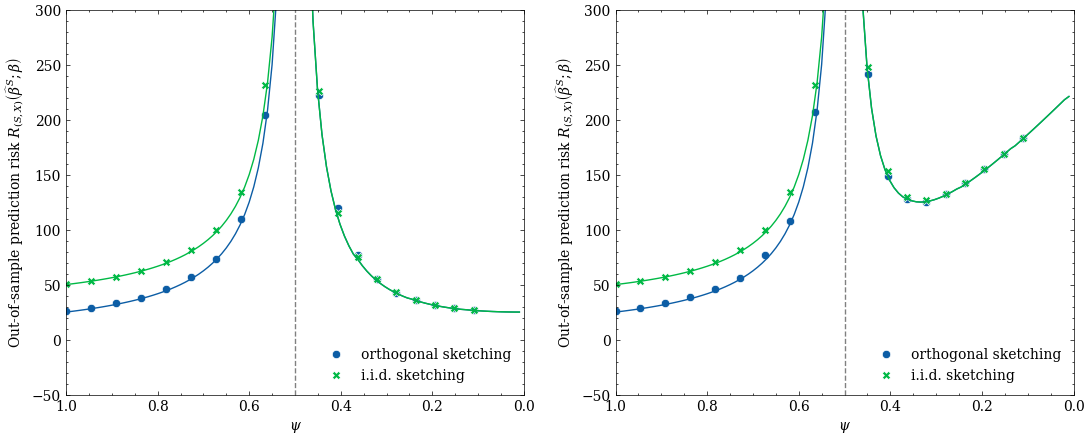

In [15]:
# Plot
with plt.style.context(['science', 'no-latex', 'std-colors']):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))

    snr, emp_psi, emp_risk, psi, risk = load_files('thm3.2_fixed_np_S_orthogonal/SNR1.0_nsim500.json')
    ax[0] = sns.scatterplot(x=emp_psi, y=emp_risk, ax=ax[0], label = "orthogonal sketching")
    ax[0] = sns.lineplot(x=psi, y=risk, ax=ax[0])
    
    snr, emp_psi, emp_risk, psi, risk = load_files('thm3.2_fixed_np_S_iid/SNR1.0_nsim500.json')
    ax[0] = sns.scatterplot(x=emp_psi, y=emp_risk, marker = 'X', ax=ax[0], label = "i.i.d. sketching")
    ax[0] = sns.lineplot(x=psi, y=risk, ax=ax[0])
    
    ax[0].set_ylim(-50, 300)
    ax[0].set_xlim(0, 1)
    
    ax[0].axvline(x=0.5, color="grey", linestyle='dashed', linewidth=1)
    #ax[0].set_title("Isotropic features, SNR = 1.0")
    ax[0].invert_xaxis()
    ax[0].legend(loc='lower right')
    ax[0].set_ylabel(r"Out-of-sample prediction risk $R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$")
    ax[0].set_xlabel(r"$\psi$")
    
    snr, emp_psi, emp_risk, psi, risk = load_files('thm3.2_fixed_np_S_orthogonal/SNR3.0_nsim500.json')
    ax[1] = sns.scatterplot(x=emp_psi, y=emp_risk, label = "orthogonal sketching", ax=ax[1])
    ax[1] = sns.lineplot(x=psi, y=risk, ax=ax[1])

    snr, emp_psi, emp_risk, psi, risk = load_files('thm3.2_fixed_np_S_iid/SNR3.0_nsim500.json')
    ax[1] = sns.scatterplot(x=emp_psi, y=emp_risk, marker = 'X', ax=ax[1], label = "i.i.d. sketching")
    ax[1] = sns.lineplot(x=psi, y=risk, ax=ax[1])

    ax[1].set_ylim(-50, 300)
    ax[1].set_xlim(0, 1)
    ax[1].axvline(x=0.5, color="grey", linestyle='dashed', linewidth=1)
    #ax[1].set_title("Isotropic features, SNR = 3.0")
    ax[1].invert_xaxis()
    ax[1].legend(loc='lower right')

    ax[1].set_ylabel(r"Out-of-sample prediction risk $R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$")
    ax[1].set_xlabel(r"$\psi$")

    plt.savefig('figure1.pdf', dpi=400, facecolor='w', edgecolor='w', pad_inches=None)
    plt.show()

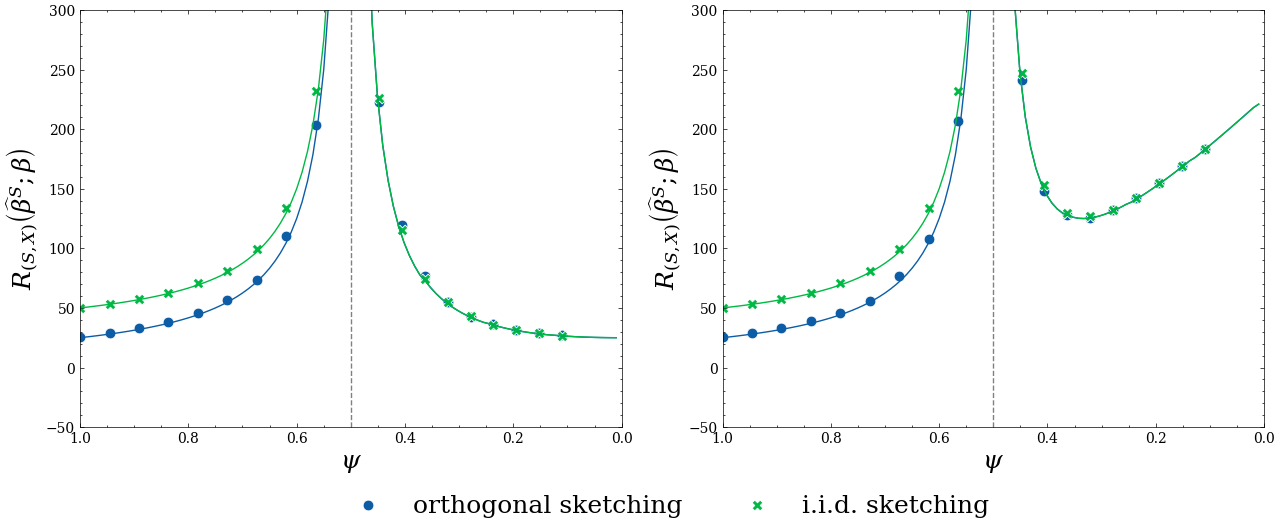

In [8]:
# Plot
with plt.style.context(['science', 'no-latex', 'std-colors']):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))

    snr, emp_psi, emp_risk, psi, risk = load_files('thm3.2_fixed_np_S_orthogonal/SNR1.0_nsim500.json')
    ax[0] = sns.scatterplot(x=emp_psi, y=emp_risk, ax=ax[0], s=60, label = "orthogonal sketching")
    ax[0] = sns.lineplot(x=psi, y=risk, ax=ax[0])
    
    snr, emp_psi, emp_risk, psi, risk = load_files('thm3.2_fixed_np_S_iid/SNR1.0_nsim500.json')
    ax[0] = sns.scatterplot(x=emp_psi, y=emp_risk, marker = 'X', ax=ax[0], s=60, label = "i.i.d. sketching")
    ax[0] = sns.lineplot(x=psi, y=risk, ax=ax[0])
    
    ax[0].set_ylim(-50, 300)
    ax[0].set_xlim(0, 1)
    
    ax[0].axvline(x=0.5, color="grey", linestyle='dashed', linewidth=1)
    #ax[0].set_title("Isotropic features, SNR = 1.0")
    ax[0].invert_xaxis()
    ax[0].legend(loc='lower right')
    ax[0].set_ylabel(r"$R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$", fontsize=18)
    ax[0].set_xlabel(r"$\psi$", fontsize=18)
    
    snr, emp_psi, emp_risk, psi, risk = load_files('thm3.2_fixed_np_S_orthogonal/SNR3.0_nsim500.json')
    ax[1] = sns.scatterplot(x=emp_psi, y=emp_risk, label = "orthogonal sketching",s=60,  ax=ax[1])
    ax[1] = sns.lineplot(x=psi, y=risk, ax=ax[1])

    snr, emp_psi, emp_risk, psi, risk = load_files('thm3.2_fixed_np_S_iid/SNR3.0_nsim500.json')
    ax[1] = sns.scatterplot(x=emp_psi, y=emp_risk, marker = 'X', ax=ax[1], s=60, label = "i.i.d. sketching")
    ax[1] = sns.lineplot(x=psi, y=risk, ax=ax[1])

    ax[1].set_ylim(-50, 300)
    ax[1].set_xlim(0, 1)
    ax[1].axvline(x=0.5, color="grey", linestyle='dashed', linewidth=1)
    #ax[1].set_title("Isotropic features, SNR = 3.0")
    ax[1].invert_xaxis()
    ax[1].legend(loc='lower right')

    ax[1].set_ylabel(r"$R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$", fontsize=18)
    ax[1].set_xlabel(r"$\psi$", fontsize=18)

    ax[0].get_legend().remove()
    ax[1].get_legend().remove()

    handles, labels = ax[0].get_legend_handles_labels()
 
    #handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.52, -0.1), ncol = 3, prop={'size':18})
    plt.tight_layout()

    plt.savefig('figure1.pdf', dpi=400, facecolor='w', edgecolor='w', pad_inches=None)
    plt.show()